# covid-nsw
Driven by SQL, I explore [NSW COVID-19 cases by location](https://data.nsw.gov.au/search/dataset/ds-nsw-ckan-aefcde60-3b0c-4bc0-9af1-6fe652944ec2/details?q=).

## Setup

Create SQL engine and load input CSV into a SQLite table:

In [1]:
from glob import glob
import pandas as pd
from sqlalchemy import create_engine

engine = create_engine("sqlite://", echo=False)

covid_df = pd.read_csv(glob("./input/confirmed_cases*.csv")[0])
covid_df.to_sql("covid", engine, if_exists="replace", index=False)
covid_df.head(3)


,notification_date,postcode,lhd_2010_code,lhd_2010_name,lga_code19,lga_name19,confirmed_by_pcr,confirmed_cases_count
0,2020-01-25,2071,X760,Northern Sydney,14500,Ku-ring-gai (A),NaN,1
1,2020-01-25,2121,X760,Northern Sydney,16260,Parramatta (C),NaN,1
2,2020-01-25,2134,X700,Sydney,11300,Burwood (A),NaN,1


## Cleaning

### Missing
There are missing values in both `postcode` and `confirmed_by_pcr` columns:

In [2]:
pd.read_sql_query(
    """
    SELECT SUM(CASE WHEN notification_date IS NULL THEN 1 ELSE 0 END) AS 'nd_miss',
        SUM(CASE WHEN postcode IS 'None' THEN 1 ELSE 0 END) AS 'pc_miss',
        SUM(CASE WHEN lhd_2010_code IS  NULL THEN 1 ELSE 0 END) AS 'lhdc_miss',
        SUM(CASE WHEN lhd_2010_name IS NULL THEN 1 ELSE 0 END) AS 'lhdn_miss',
        SUM(CASE WHEN lga_code19 IS NULL THEN 1 ELSE 0 END) AS 'lgac_miss',
        SUM(CASE WHEN lga_name19 IS NULL THEN 1 ELSE 0 END) AS 'lgan_miss',
        SUM(CASE WHEN confirmed_by_pcr IS NULL THEN 1 ELSE 0 END) AS 'pcr_miss',
        SUM(CASE WHEN confirmed_cases_count IS NULL THEN 1 ELSE 0 END) AS 'confirmed_cases_miss'
    FROM covid
""",
    engine,
)


,nd_miss,pc_miss,lhdc_miss,lhdn_miss,lgac_miss,lgan_miss,pcr_miss,confirmed_cases_miss
0,0,530,0,0,0,0,41075,0


Although Local Government Area (LGA) information is not missing for rows with missing `postcode`, `postcode` is nevertheless difficult to impute as there can be multiple postcodes in an LGA (1:M).

Similarly, `confirmed_by_pcr` is difficult to impute. It records whether a case detected by Rapid Antigen Tests (RAT), reported to NSW Health, was also confirmed by PCR. All missing values were prior to 19 Jan 2022 and would be difficult to impute.

In [3]:
pd.read_sql_query(
    """
        SELECT MAX(notification_date) AS 'latest_pcr_miss_date'
        FROM covid
        WHERE confirmed_by_pcr IS NULL
    """,
    engine,
)


,latest_pcr_miss_date
0,2022-01-19


## Analysis
In this section, I use SQL queries and Python visualisations to highlight insights in the data.

### Daily Cases
Daily reported cases have overall trended upwards since reporting started on 25 Jan 2020. Daily cases peaked in Jan 2022, and then, less so, in Mar 2022. 

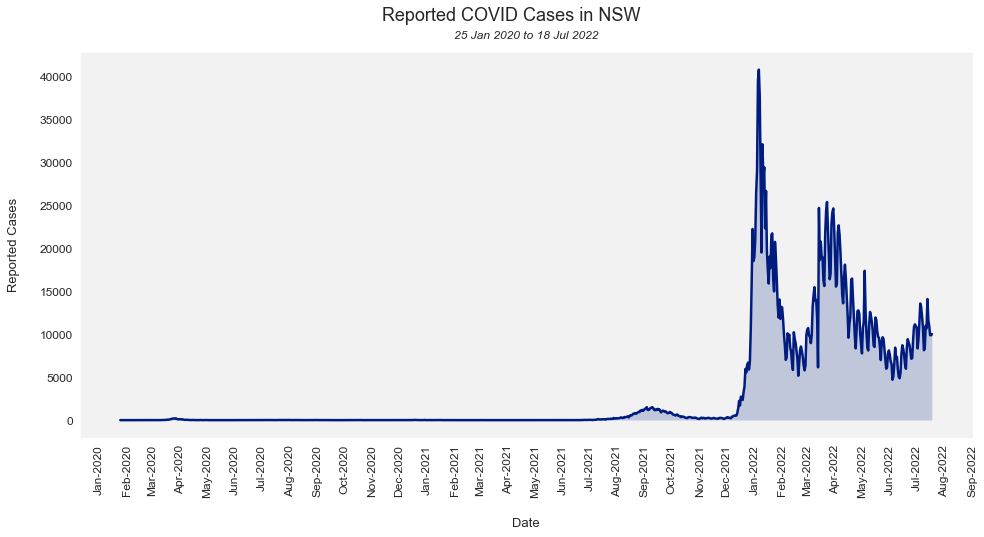

<Figure size 432x288 with 0 Axes>

In [27]:
import matplotlib.pyplot as plt
import matplotlib.dates as md
import seaborn as sns

# querying
daily_cases =\
    pd.read_sql_query("""
        SELECT DATE(notification_date) AS 'date',
            SUM(confirmed_cases_count) AS 'reported_cases'
        FROM covid
        GROUP BY 1
    """, engine)

# transforming and extracting from DataFrame for visualisation
daily_cases["date"] = pd.to_datetime(daily_cases["date"], format="%Y-%m-%d")
start_date = daily_cases.date.min().strftime("%d %b %Y")
end_date = daily_cases.date.max().strftime("%d %b %Y")

# plotting visualisation
sns.set_style("dark", {"axes.facecolor": "0.95"})
sns.set_palette("dark")

fig, ax = plt.subplots(figsize=(16, 7))
sns.lineplot(x="date",
             y="reported_cases",
             data=daily_cases,
             ax=ax,
             linewidth=2.5)
plt.fill_between(x=daily_cases["date"], 
                 y1=daily_cases["reported_cases"],
                 alpha=0.2)

# setting x-axis ticks
ax.xaxis.set_major_locator(md.MonthLocator(bymonthday=1))
ax.xaxis.set_major_formatter(md.DateFormatter("%b-%Y"))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
ax.tick_params(axis="both", labelsize=12)

# modifying line-chart parameters
ax.figure.suptitle("Reported COVID Cases in NSW", fontsize=18)
ax.set_title(f"{start_date} to {end_date}", y=1.02, style="italic")
ax.set_xlabel("Date", fontsize=13, labelpad=20)
ax.set_ylabel("Reported Cases", fontsize=13, labelpad=20)

fig.subplots_adjust(top=0.89)

plt.show()
plt.clf()


### COULD LABEL THIS WITH ANNOTATIONS OF THE ALL OF THE WAVES!

Drilling down, we see that the **10 highest daily reported cases all occurred in January 2022.** 11th to 16th highest are in the smaller, March 2022 spike in the line chart above.

In [5]:
pd.read_sql_query(
    """
    SELECT
        RANK() OVER (
            ORDER BY SUM(confirmed_cases_count) DESC
        ) AS 'rank',
        DATE(notification_date) AS 'date',
        STRFTIME('%m-%Y', notification_date) AS 'month_year',
        SUM(confirmed_cases_count) AS 'reported_cases'
    FROM covid
    GROUP BY 2
    ORDER BY 4 DESC
    LIMIT 20
""",
    engine,
)


,rank,date,month_year,reported_cases
0,1,2022-01-06,01-2022,40752
1,2,2022-01-05,01-2022,39431
2,3,2022-01-07,01-2022,37676
3,4,2022-01-10,01-2022,32070
4,5,2022-01-12,01-2022,29411
5,6,2022-01-04,01-2022,29031
6,7,2022-01-08,01-2022,28174
7,8,2022-01-11,01-2022,28137
8,9,2022-01-14,01-2022,26646
9,10,2022-01-03,01-2022,26374


#### "Zero" days
Since reporting began, there have been days with no COVID cases reported to NSW Health. 

We can see from the below query that:
* February 2020 was an entire _month_ of zero days
* Since 12 June 2021, there have been no zero days

In [6]:
zero_days_df = pd.read_sql_query(
    """
        WITH RECURSIVE dates(date) AS (
            VALUES((
                SELECT MIN(notification_date)
                FROM covid
                )
            )
            UNION ALL
            SELECT DATE(date, '+1 day')
            FROM dates
            WHERE date < (
                SELECT MAX(notification_date)
                FROM covid
                )
            )

        SELECT
            d.*
        FROM dates d
        LEFT JOIN covid c
            ON c.notification_date = d.date
        WHERE c.notification_date IS NULL
        ORDER BY 1
        """,
    engine,
)

zero_days_df.to_sql("zero_days", engine, if_exists="replace", index=False)
zero_days_df

,date
0,2020-01-26
1,2020-01-28
2,2020-01-29
3,2020-01-30
4,2020-01-31
...,...
86,2021-05-31
87,2021-06-01
88,2021-06-03
89,2021-06-11


In [7]:
pd.read_sql_query("""
    SELECT STRFTIME('%Y-%m', date) AS 'year_month',
        COUNT(*) AS 'zero_days_count'
    FROM zero_days
    GROUP BY 1
    ORDER BY 1
""", engine)

,year_month,zero_days_count
0,2020-01,5
1,2020-02,29
2,2020-05,9
3,2020-06,4
4,2020-09,3
5,2020-10,1
6,2020-11,3
7,2021-01,7
8,2021-02,10
9,2021-03,6


##### Streaks
As of the last date in the data, there have the following number of days since the last "zero day":

In [8]:
from IPython.display import Markdown
import numpy as np

last_zeroday = pd.to_datetime(zero_days_df.date.max())
days_since_zero = round((daily_cases.date.max() - last_zeroday) /\
                        np.timedelta64(1, 'D'))

display(Markdown(f"""
<div align='center'> Days since last zero day:</div>
<h1 align='center'>{days_since_zero}</h1>"""))


<div align='center'> Days since last zero day:</div>
<h1 align='center'>401</h1>

Since reporting started, the longest streak of "zero days" was 33 days, starting on 28 Jan 2020, and broken on 1 March 2020: 

In [9]:
# I minus 1 day from the difference between two dates where there were 1+ reported cases, as continuous days will return 1, but the streak is 0.

zd_streaks = \
    pd.read_sql_query("""
        WITH daily_cases AS (
            SELECT DATE(notification_date) AS 'date',
                SUM(confirmed_cases_count) AS 'reported_cases'
            FROM covid
            GROUP BY 1
        )

        SELECT *
        FROM (
            SELECT date AS 'date_streak_broken', 
                ROUND(
                    JULIANDAY(date) 
                    - JULIANDAY(
                            LAG(date) OVER (
                                ORDER BY date
                            )
                    )
                - 1) AS 'date_diff'
            FROM daily_cases
        )
        WHERE date_diff > 0

    """, engine)

# we filter out where `date_diff` = 0, as this means there were no zero days in between those dates

zd_streaks['date_diff'] = zd_streaks['date_diff'].astype(int)

zd_streaks

,date_streak_broken,date_diff
0,2020-01-27,1
1,2020-03-01,33
2,2020-05-12,2
3,2020-05-18,3
4,2020-05-23,1
5,2020-05-28,2
6,2020-05-30,1
7,2020-06-06,1
8,2020-06-11,1
9,2020-06-17,2


Examining the distribution:
* The 33-day zero-day streak above is an outlier,
* The vast majority (72%) of zero days were isolated; breaking up continuous days of reported cases.

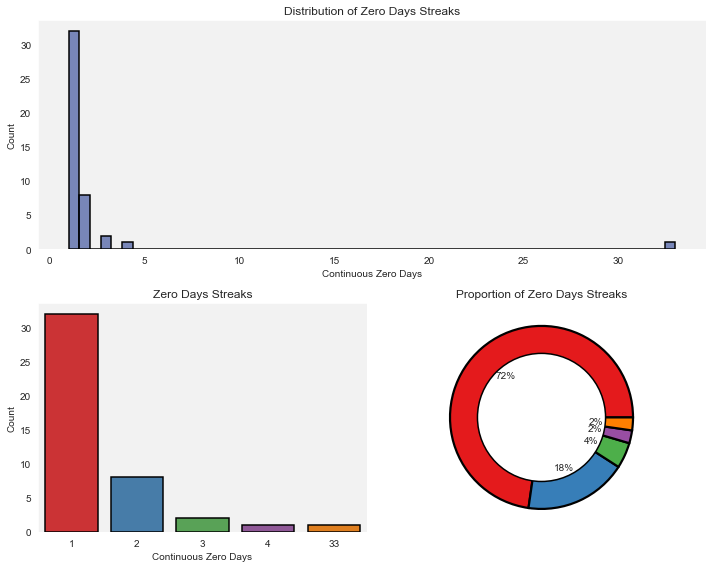

<Figure size 432x288 with 0 Axes>

In [53]:
import matplotlib.gridspec as gridspec

gs = gridspec.GridSpec(2,2)
f = plt.figure(figsize=(10,8))

# histogram for distribution
sns.set_palette("dark")
zd_hist = f.add_subplot(gs[:-1,:])
sns.histplot(data=zd_streaks, x="date_diff", 
             alpha=0.5,
             legend=False,
             edgecolor="black", linewidth=1.5)\
    .set_xlabel("Continuous Zero Days")
plt.title("Distribution of Zero Days Streaks")

# countplot for distribution
sns.set_palette("Set1")
zd_countp = f.add_subplot(gs[1,0])
sns.countplot(data=zd_streaks, x='date_diff', edgecolor="black", linewidth=1.5)\
    .set_xlabel("Continuous Zero Days")
plt.title("Zero Days Streaks")
plt.ylabel("Count")

# donut chart for proportion
zd_prop = f.add_subplot(gs[1,1])
## transforming table for donut chart generation
zd_streaks_count =\
    zd_streaks\
        .groupby('date_diff').count()\
        .reset_index()\
        .rename(columns={'date_streak_broken': 
                         'date_diff_count'})
zd_donut =\
    plt.pie(zd_streaks_count['date_diff_count'],
        wedgeprops={'linewidth': 2.2, 
                    'edgecolor': 'black'},
        autopct="%d%%")
plt.title("Proportion of Zero Days Streaks")

my_circle = plt.Circle((0,0), 
                       0.7, 
                       facecolor='white', 
                       edgecolor="black", 
                       linewidth=1.5)
p = plt.gcf()
p.gca().add_artist(my_circle)


gs.tight_layout(f)
plt.show()
plt.clf()

In [ ]:
### potential insights:
# correlation between population (latest data) and COVID cases (per capita) in LGA/postcode
# correlation between taxable income (latest data) and COVID cases in each LGA/postcode
# last LGAs standing (last to have reported COVID case)
# covid cases and covid-related infringement notices